In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import Dropdown, interactive, widgets, Output

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import Dropdown, interactive, widgets, Output
from scipy.interpolate import make_interp_spline

In [126]:
# Define the column headers\n",
headers = ['frame', 'classid','id', 'x1', 'y1', 'width', 'height','a','b','c','d']

# Provide the path to your CSV file\n",
csv_file_path = 'D:/MELA/ANNOTATION ANALYSIS/20230310_SE_Lek1_P1D1_DJI_0190.CSV'
# Read the CSV file into a DataFrame and assign the headers\n",
df_in = pd.read_csv(csv_file_path, header=None, names=headers)
# Display the DataFrame\n",
print(df_in)

        frame  classid   id    x1    y1  width  height  a  b  c  d
0           0        2    0  2676  1501     33      29 -1 -1 -1 -1
1           0        1    0   307  2442     33      27 -1 -1 -1 -1
2           0        1    2   754  2153     25      33 -1 -1 -1 -1
3           0        1    3   869  2140     28      34 -1 -1 -1 -1
4           0        1    5   746  1993     26      30 -1 -1 -1 -1
...       ...      ...  ...   ...   ...    ...     ... .. .. .. ..
400032   5804        0  102  2827  1434     52      36 -1 -1 -1 -1
400033   5804        0  104   388  2915     56      35 -1 -1 -1 -1
400034   5804        0  106  2354  2885     34      43 -1 -1 -1 -1
400035   5804        0  107   290   517     50      50 -1 -1 -1 -1
400036   5804        1    8   177  2364     44      37 -1 -1 -1 -1

[400037 rows x 11 columns]


In [102]:
df_in['area'] = df_in['width'] * df_in['height']

# Find the number of unique frames in the 'frames' column of df_in
unique_frames_count = df_in['frame'].nunique()

unique_individuals = df_in[['classid', 'id']].drop_duplicates()

# Remove entries with classid 2 or -1 from unique_individuals DataFrame
unique_individuals = unique_individuals[(unique_individuals['classid'] != 2) & (unique_individuals['classid'] != -1)]

# Calculate the total number of unique individuals
total_individuals = len(unique_individuals)




In [129]:
#Finding classid error

# Create a new column 'classid_error' and initialize it with 0
df_in['classid_error'] = 0

# Function to update 'classid_error' column based on 'classid' column
def update_classid_error(row):
    if row['classid'] == -1:
        return 1
    else:
        return row['classid_error']

# Apply the update_classid_error function to each row
df_in['classid_error'] = df_in.apply(update_classid_error, axis=1)

df_in['classid_error_frame'] = 0

# Find frames with 'classid_error' entry of 1
frames_with_classid_error = df_in[df_in['classid_error'] == 1]['frame'].unique()

# Update 'classid_error_frame' column for the identified frames
df_in.loc[df_in['frame'].isin(frames_with_classid_error), 'classid_error_frame'] = 1

# Print frames with duplicates
print("Frames with classid errors:", frames_with_classid_error)

Frames with classid errors: [3828 4173 5801 2209 4805 2602]


In [130]:
#Finding duplicate frames

# Create a new column 'duplicates' indicating if a row is a duplicate
df_in['duplicates'] = df_in.groupby(['frame', 'classid'])['id'].transform(lambda x: x.duplicated(keep=False).astype(int))

# Find unique frames with duplicates
frames_with_duplicates = df_in.loc[df_in['duplicates'] == 1, 'frame'].unique()

# Create 'duplicate_frame' column and set values based on 'frame' and 'frames_with_duplicates'
df_in['duplicate_frame'] = df_in['frame'].apply(lambda x: 1 if x in frames_with_duplicates else 0)

# Print frames with duplicates
print("Frames with Duplicates:", frames_with_duplicates)

# Display the updated DataFrame
#print(df_in)

Frames with Duplicates: [3828 2209 4173 4805 5801]


In [131]:
#Disappearing reappearing error
# Sort the DataFrame by 'id' and 'frame' in ascending order
df_in.sort_values(by=['id', 'frame'], inplace=True)

# Create a dictionary to store the last frame for each individual
last_frame_dict = {}
disappearance_statements = []  # Initialize a list to store disappearance statements

# Iterate through the DataFrame
for index, row in df_in.iterrows():
    classid = row['classid']
    individual_id = row['id']
    frame = row['frame']

    # Check if the individual was present in the previous frame
    if (classid, individual_id) in last_frame_dict:
        last_frame = last_frame_dict[(classid, individual_id)]

        if frame != last_frame + 1:
            statement = f"ID {individual_id} (Class {classid}) disappeared in frame {last_frame} and reappeared in frame {frame}"
            disappearance_statements.append(statement)  # Collect the statements

    # Update the last frame for the individual
    last_frame_dict[(classid, individual_id)] = frame

# Create a new list without entries containing 'Class -1' and not having one less of the numbers stored in 'frames_with_classid_error'
filtered_disappearance_statements = [
    statement for statement in disappearance_statements 
    if 'Class -1' not in statement 
    and all(f"frame {frame - 1}" not in statement for frame in frames_with_classid_error)
    and all(f"frame {frame}" not in statement for frame in frames_with_duplicates)
]


# Print the filtered list
for statement in filtered_disappearance_statements:
    print(statement)



ID 8 (Class 1) disappeared in frame 4852 and reappeared in frame 4854


In [132]:
#max distance travelled by each individual
import pandas as pd

# Assuming you have the DataFrame df_in

# Sort the DataFrame by 'classid', 'id', and 'frame' in ascending order
df_in.sort_values(by=['classid', 'id', 'frame'], inplace=True)

# Create two new columns to store the distances
df_in['distance_x'] = 0
df_in['distance_y'] = 0

# Create a dictionary to store the last coordinates for each individual within each class
last_coords_dict = {}

# Iterate through the DataFrame
for index, row in df_in.iterrows():
    classid = row['classid']
    individual_id = row['id']
    frame = row['frame']
    x = row['x1']
    y = row['y1']

    # Check if the individual within a class was present in the previous frame
    if (classid, individual_id) in last_coords_dict:
        last_x, last_y = last_coords_dict[(classid, individual_id)]

        # Calculate the distance in x and y coordinates
        distance_x = abs(x - last_x)
        distance_y = abs(y - last_y)

        # Update the DataFrame with the calculated distances
        df_in.at[index, 'distance_x'] = distance_x
        df_in.at[index, 'distance_y'] = distance_y

    # Update the last coordinates for the individual within the class
    last_coords_dict[(classid, individual_id)] = (x, y)


# Filter rows where either 'distance_x' or 'distance_y' is greater than 60
row_with_distance_60 = df_in[(df_in['distance_x'] > 60) | (df_in['distance_y'] > 60)]

# Now you can print or work with the rows where either 'distance_x' or 'distance_y' is greater than 60

frames_unique_individuals_60 = row_with_distance_60[(row_with_distance_60['classid'] != -1) & (row_with_distance_60['classid'] != 2)]
frames_unique_entries_60 = frames_unique_individuals_60['frame'].nunique()


print(frames_unique_entries_60)

# Get the unique combination of 'classid' and 'id' values for all individuals
unique_individuals_60 = row_with_distance_60[['classid', 'id']].drop_duplicates()


unique_individuals_60 = unique_individuals_60[(unique_individuals_60['classid'] != -1) & (unique_individuals_60['classid'] != 2)]
# Calculate the total number of unique individuals
total_individuals_60 = len(unique_individuals_60)

# Print the total number of unique individuals
print("Total Number of Unique Individuals (Male and Female):", total_individuals_60)




8
Total Number of Unique Individuals (Male and Female): 8


In [85]:
# Filter rows where 'area' is greater than 4000
rows_with_high_area = df_in[df_in['area'] > 4000]

frames_unique_high_area = rows_with_high_area[(rows_with_high_area['classid'] != -1) & (rows_with_high_area['classid'] != 2)]
frames_unique_entries_area = frames_unique_high_area['frame'].nunique()

# Print the number of unique entries
print("Number of unique entries in the 'frame' column:", frames_unique_entries_area)


# Get the unique combination of 'classid' and 'id' values for all individuals
unique_individuals_area = rows_with_high_area[['classid', 'id']].drop_duplicates()

unique_individuals_area = unique_individuals_area[(unique_individuals_area['classid'] != -1) & (unique_individuals_area['classid'] != 2)]

# Calculate the total number of unique individuals
total_individuals_area = len(unique_individuals_area)

# Print the total number of unique individuals
print("Total Number of Unique Individuals (Male and Female):", total_individuals_area)

Number of unique entries in the 'frame' column: 80
Total Number of Unique Individuals (Male and Female): 4


In [91]:
# Create an empty DataFrame to store the results
df_area = unique_individuals_area.copy()

# Function to count frames where area > 4000 for an individual
def count_frames_above_4000(classid, individual_id):
    filtered_df = df_in[(df_in['classid'] == classid) & (df_in['id'] == individual_id)]
    frames_above_4000 = len(filtered_df[filtered_df['area'] > 4000])
    return frames_above_4000

# Apply the function to each row of df_area and store the result in a new column
df_area['no of frames>4000'] = df_area.apply(lambda row: count_frames_above_4000(row['classid'], row['id']), axis=1)

# Display the resulting DataFrame
print(df_area)

# Create an empty list to store the statements
statements_area = []

# Function to count frames where area > 4000 for an individual and generate statements
def generate_statements(classid, individual_id):
    filtered_df = df_in[(df_in['classid'] == classid) & (df_in['id'] == individual_id)]
    frames_above_4000 = len(filtered_df[filtered_df['area'] > 4000])
    
    # Generate the statement and append it to the list
    statement = f"ID {individual_id} of Class {classid} has area above 4000 in {frames_above_4000} number of frames."
    statements_area.append(statement)

# Apply the function to each row of df_area
df_area.apply(lambda row: generate_statements(row['classid'], row['id']), axis=1)

# Print the generated statements
for statement in statements_area:
    print(statement)


       classid  id  no of frames>4000
28313        0   1                 10
9486         0   3                 26
63317        0  15                 27
24988        1   0                 17
ID 1 of Class 0 has area above 4000 in 10 no of frames.
ID 3 of Class 0 has area above 4000 in 26 no of frames.
ID 15 of Class 0 has area above 4000 in 27 no of frames.
ID 0 of Class 1 has area above 4000 in 17 no of frames.


C:\Users\user\AppData\Local\Temp\ipykernel_10768\3227789579.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


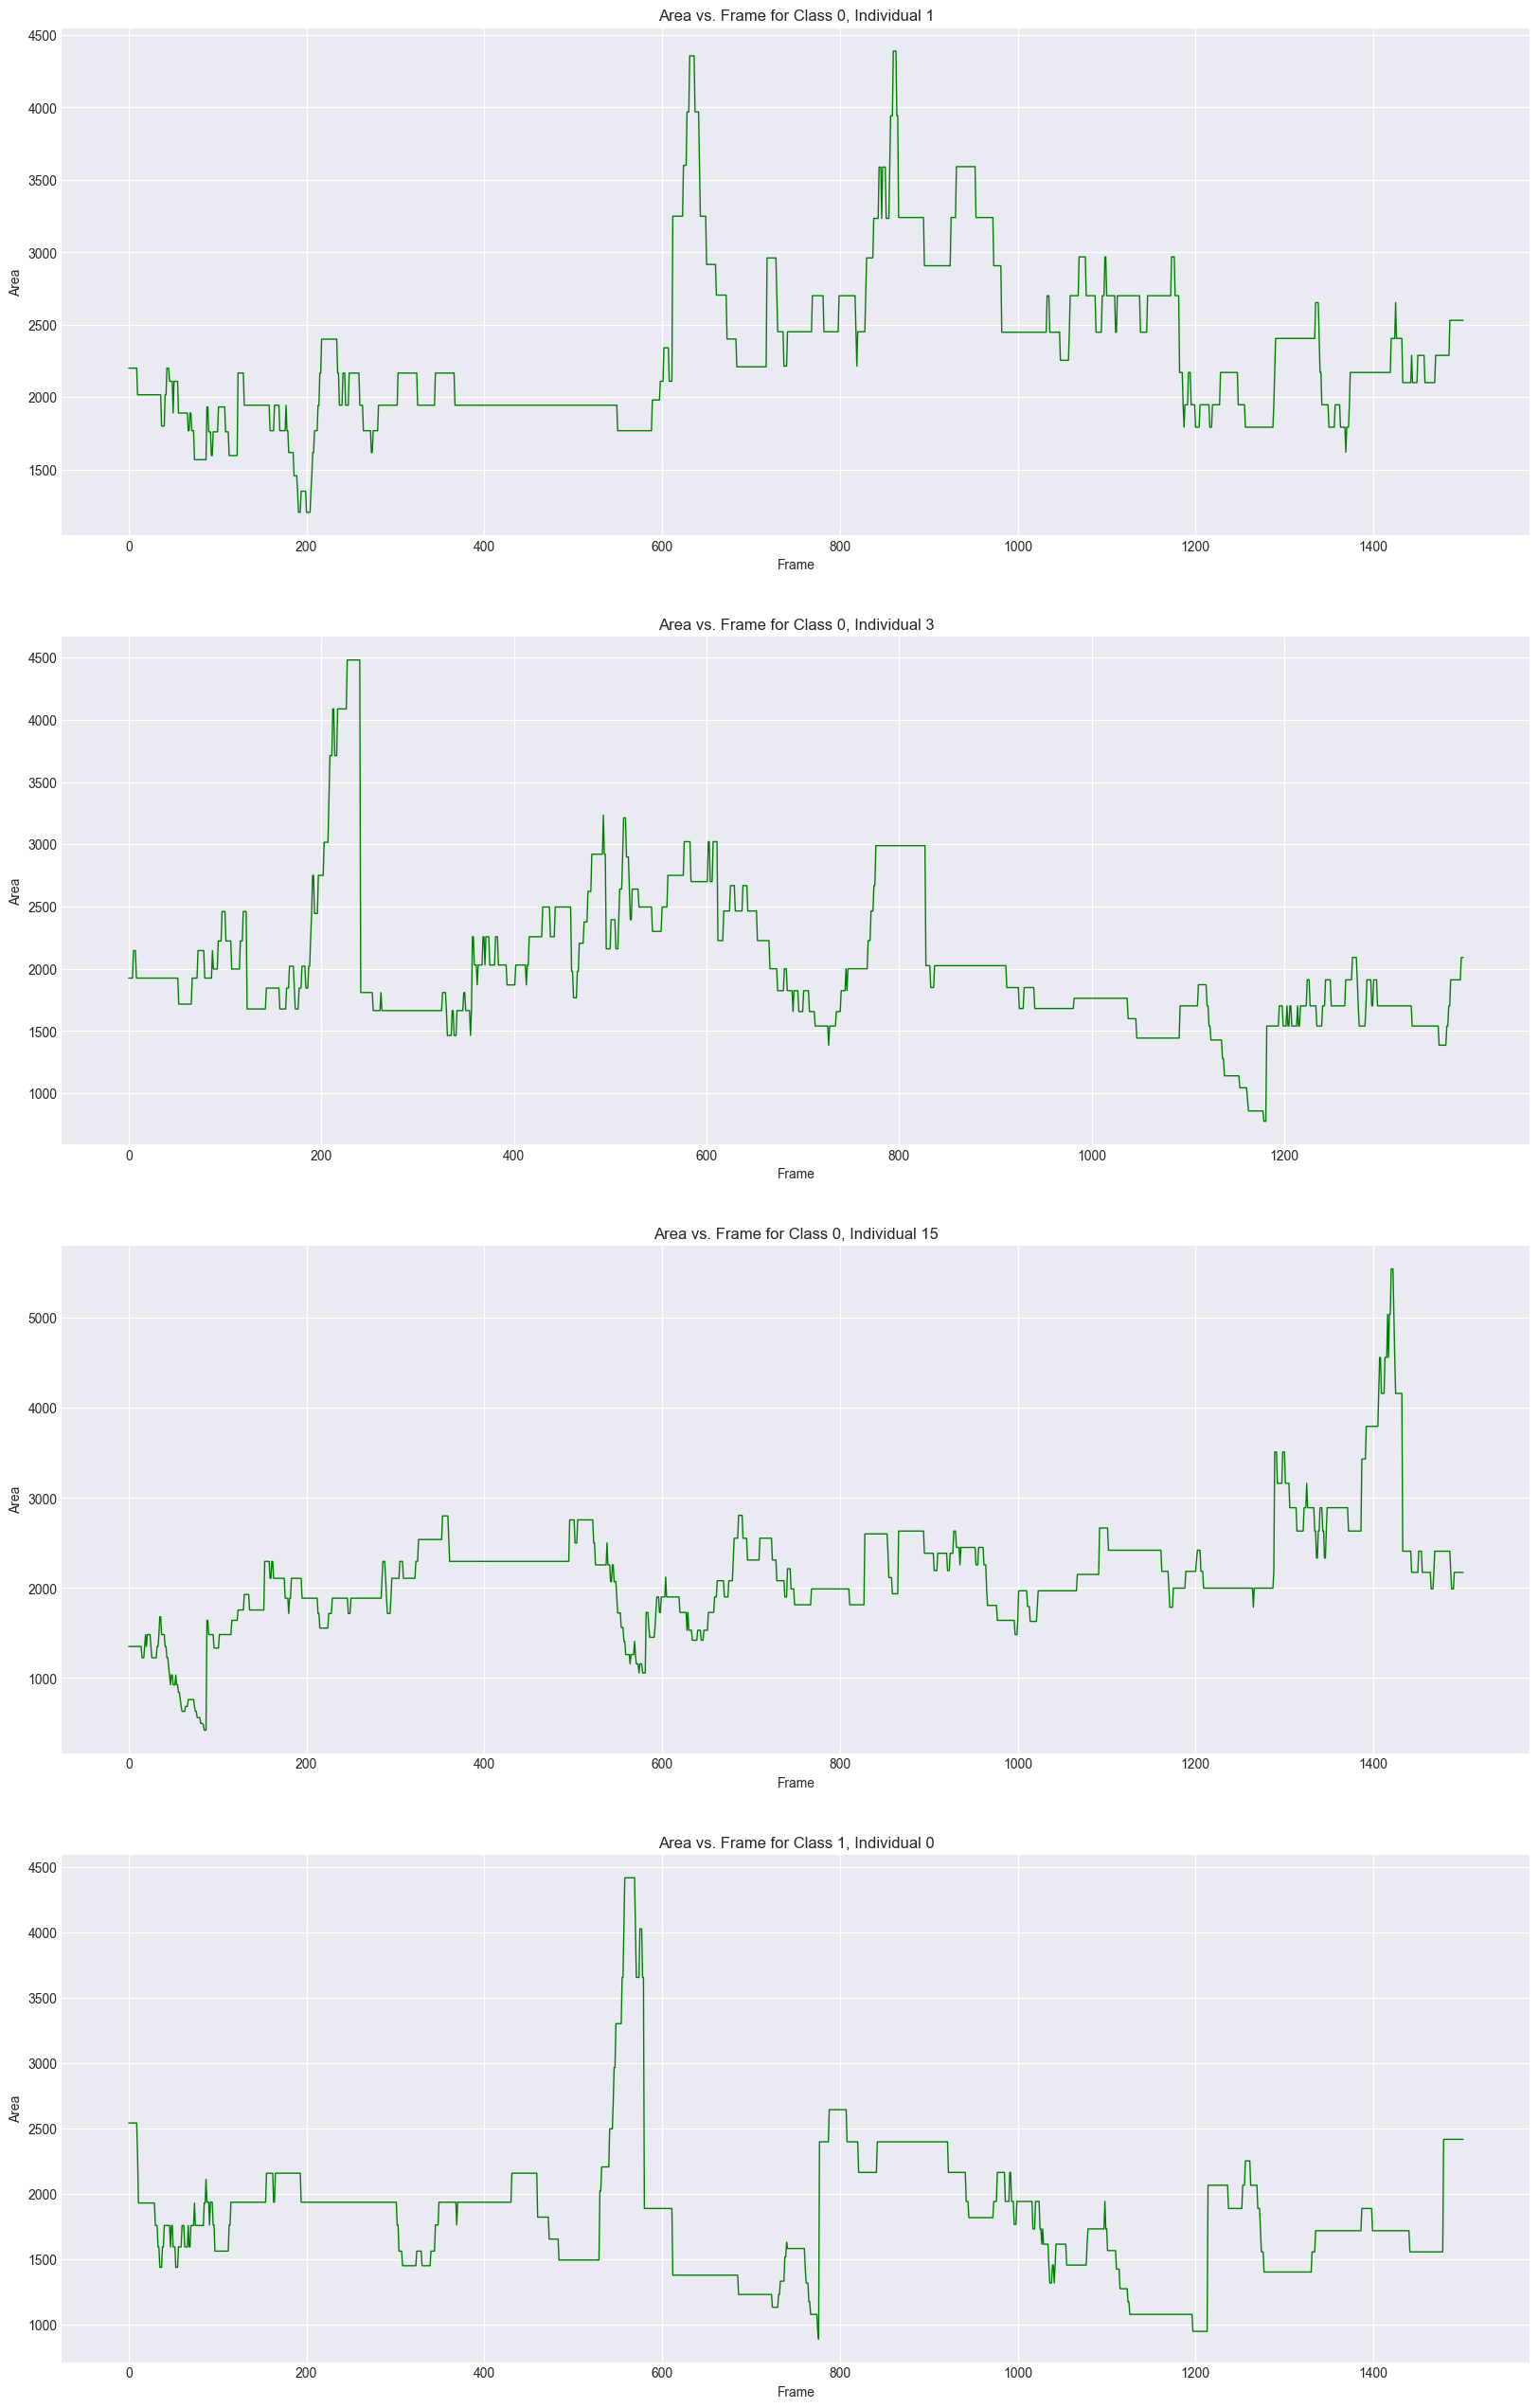

In [86]:
# Set the style with a gray background
plt.style.use('seaborn-dark')

# Extract the CSV file name without the extension
csv_file_name = os.path.splitext(os.path.basename(csv_file_path))[0]

# Create a single figure to contain all plots
fig, axes = plt.subplots(len(unique_individuals_area), 1, figsize=(20, 8 * len(unique_individuals_area)))

# Function to plot graphs for each unique combination
def create_individual_plots(df, unique_individuals_area):
    for i, (_, row) in enumerate(unique_individuals_area.iterrows()):
        classid, individual_id = row['classid'], row['id']

        # Select the current subplot
        ax = axes[i]

        # Clear the previous plot from the subplot
        ax.clear()

        filtered_df = df[(df['classid'] == classid) & (df['id'] == individual_id)]
        grouped_df = filtered_df.groupby('frame')['area'].mean()

        ax.set_title(f'Area vs. Frame for Class {classid}, Individual {individual_id}')
        ax.set_xlabel('Frame')
        ax.set_ylabel('Area')

        # Plot the data points with a slight curve
        x = grouped_df.index
        y = grouped_df.values
        ax.plot(x, y, color='green', linestyle='-', linewidth=1)  # Adjust the linewidth for a thicker line

        # Set X axis ticks to be every 30 frames
        ax.set_xticks(range(0, max(x) + 1, 200))

        # Show gridlines
        ax.grid(True)

# Call the function to create individual plots
create_individual_plots(df_in, unique_individuals_area)

# Save the figure containing all plots with the CSV file name as part of the filename
image_filename = f'{csv_file_name}_all_plots.png'
fig.savefig(image_filename, bbox_inches='tight', format='png')

# Show the figure (optional, comment this line to save only)
plt.show()


In [16]:
print(row_with_distance_60)

        frame  classid  id    x1    y1  width  height  a  b  c  d  area  \
141489   3620       -1   4  3548  2258     47      40 -1 -1 -1 -1  1880   
141490   3620       -1   5  3423  2146     44      50 -1 -1 -1 -1  2200   
141491   3620       -1   6  3488  1764     53      42 -1 -1 -1 -1  2226   
141492   3620       -1   7  5176  1550     50      29 -1 -1 -1 -1  1450   
151681   3785       -1   7  5396  1571     50      29 -1 -1 -1 -1  1450   
141493   3620       -1   8  4234  2247     36      47 -1 -1 -1 -1  1692   
151682   3785       -1   8  4269  2338     36      47 -1 -1 -1 -1  1692   
141494   3620       -1   9  4139  2310     48      47 -1 -1 -1 -1  2256   
141495   3620       -1  10  4218  2305     37      34 -1 -1 -1 -1  1258   
141496   3620       -1  12  3455  1118     36      25 -1 -1 -1 -1   900   
141497   3620       -1  13  3568   324     21      28 -1 -1 -1 -1   588   
151686   3785       -1  13  3662   280     23      29 -1 -1 -1 -1   667   
141498   3620       -1  1

In [97]:
df_in.sort_values(by='frame', inplace=True)
file_name_without_extension = csv_file_path.split('/')[-1].split('.')[0]

In [98]:
# Define the new CSV file name with the desired format
new_csv_file_name = f'Analysed_{file_name_without_extension}.csv'

# Save the modified DataFrame with the new file name in the same directory
df_in.to_csv(new_csv_file_name, index=False)

In [121]:
# Check if there are frames with classid errors, duplicates, or distance greater than 60
if len(frames_with_classid_error) > 0 or len(frames_with_duplicates) > 0 or frames_unique_entries_60 > 0 or total_individuals_60 > 0 or frames_unique_entries_area > 0  or total_individuals_area > 0 or len(filtered_disappearance_statements) > 0:
    # Create a text file and write the frames with classid errors, duplicates, and error messages to it
    with open(f'Analysed_{file_name_without_extension}.txt', 'w') as file:
        if len(frames_with_classid_error) > 0:
            file.write("Frames with classid errors:\n")
            for i, frame in enumerate(frames_with_classid_error):
                file.write(str(frame))
                if i < len(frames_with_classid_error) - 1:
                    file.write(",")

            file.write("\n")  # Add a line gap

        if len(frames_with_duplicates) > 0:
            file.write("\n")  # Add a line gap
            file.write("Frames with duplicates:\n")
            for i, frame in enumerate(frames_with_duplicates):
                file.write(str(frame))
                if i < len(frames_with_duplicates) - 1:
                    file.write(",")

            file.write("\n")  # Add a line gap

        if frames_unique_entries_60 > 0:
            file.write(f"\nOut of {unique_frames_count} frames, no of frames with distance leap greater than 60: {frames_unique_entries_60}\n")
            
            file.write("\n")  # Add a line gap

        if total_individuals_60 > 0:
            file.write(f"\nOut of {len(unique_individuals)} individuals, no of Individuals with distance leap greater than 60is : {total_individuals_60}\n")
            
            file.write("\n")  # Add a line gap

        if frames_unique_entries_area > 0:
            file.write(f"\nOut of {len(unique_individuals)} frames, no of frames with bounding box area greater than 4000: {frames_unique_entries_area}\n")
            
            file.write("\n")  # Add a line gap

        if total_individuals_area > 0:
            file.write(f"\nOut of {unique_frames_count} individuals, no of individuals with bounding box area greater than 4000: {total_individuals_area}\n")
            for statement in statements_area:
                file.write(statement + '\n')
            
            file.write("\n")  # Add a line gap

        if len(filtered_disappearance_statements) > 0:
            file.write("Disappearance Statements:\n")
            for statement in filtered_disappearance_statements:
                file.write(statement + '\n')
